# Stackoverflow Tag Prediction

- <u>Problem Statement</u>: Based on the Title and Body of the question predict the tags.<br>
- It is a *multi label classification* problem. We can have multiple labels in this case. This is not a binary or multi class classification. Output can belon to multiple classes. Eg. A stackoverflow problem  can be a combination of Pthon, HTML and CSS etc. 
- For measuring model performance we use *Micro Average F1* score and *Hamming Loss* for *Multi label classification problem*

## Load Dataset
- Kaggle: https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/data
- I have used Train data as the whole dataset. Based on this I will build a model. 

In [1]:
# Using curlwidget extension to download the data

!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.93 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-IN,en;q=0.9,hi-IN;q=0.8,hi;q=0.7,ta-IN;q=0.6,ta;q=0.5,en-GB;q=0.4,en-US;q=0.3" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kagglesdsdata/competitions/3539/44369/Train.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1620807307&Signature=PQ2t%2Fet8mVeoaU3YhHDqMA1TeRY76N%2BZ3maO%2FdDtOgRojBjLAhYjuwEXa8wN1Sjscj0W0yZqGMVfbM3D3J2VDT3zRKbt4PnC17T%2F3s8a5a%2FaMdzDoZS4vx%2F2s7schaByDW1oDTQXjnHLLx9lzR%2BS78Qx4h%2F%2Bydz3WhXTTPq5ef2gczB%2Fo%2FF7mD6IQ859hyucC1bgzJE6oT158NDiO7CRfwl3gO2nwAsp6yuVMsGRulnYNm0QUYO9IsP6fuUYhJ1K8NZEH%2BL2ZKLw9GSBImfNljw7rGHKzvfWdwsE770dpgfXc7ZiWwAUQOZVKZzALaUZ7DFUcndYRE5fVxwhyBhgVg%3D%3D&response-content-disposition=attachment%3B+filename%3DTrain.zip" -c -O 'Train.zip'

--2021-05-12 06:43:43--  https://storage.googleapis.com/kagglesdsdata/competitions/3539/44369/Train.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1620807307&Signature=PQ2t%2Fet8mVeoaU3YhHDqMA1TeRY76N%2BZ3maO%2FdDtOgRojBjLAhYjuwEXa8wN1Sjscj0W0yZqGMVfbM3D3J2VDT3zRKbt4PnC17T%2F3s8a5a%2FaMdzDoZS4vx%2F2s7schaByDW1oDTQXjnHLLx9lzR%2BS78Qx4h%2F%2Bydz3WhXTTPq5ef2gczB%2Fo%2FF7mD6IQ859hyucC1bgzJE6oT158NDiO7CRfwl3gO2nwAsp6yuVMsGRulnYNm0QUYO9IsP6fuUYhJ1K8NZEH%2BL2ZKLw9GSBImfNljw7rGHKzvfWdwsE770dpgfXc7ZiWwAUQOZVKZzALaUZ7DFUcndYRE5fVxwhyBhgVg%3D%3D&response-content-disposition=attachment%3B+filename%3DTrain.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2347110159 (2.2G) [application/zip]
Saving to: ‘Train.zip’

Train.zip           100%[===============

In [2]:
# Installing patool package for extracting the zipped file
!pip install patool

     |████████████████████████████████| 81kB 7.3MB/s 


In [3]:
# Extracting the contents from Train.zip file
import patoolib
patoolib.extract_archive("/content/Train.zip")

patool: Extracting /content/Train.zip ...
patool: running /usr/bin/7z x -o./Unpack_zozwzprb -- /content/Train.zip
patool: ... /content/Train.zip extracted to `Train.csv'.


'Train.csv'

## Read Dataset

In [4]:
import os
import pandas as pd

file_stats = os.stat("/content/Train.csv")
file_size = round(file_stats.st_size/(1024*1024*1024), 1)
data = pd.read_csv("/content/Train.csv")

print(f'File size: {file_size} GB')
print(f'Columns: {data.columns.values}')
print(f'Shape: {data.shape}')

File size: 6.8 GB
Columns: ['Id' 'Title' 'Body' 'Tags']
Shape: (6034195, 4)


In [5]:
# Checking head of the data
data.head(3)

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning


## Exploratory Data Analysis

In [6]:
# We have more than 6 lakh (or 600 thousand) records. We will remove duplicates on the basis of Title, Body, Tags and fill empty string where Tags are missing.
data = data.drop_duplicates(subset=['Title', 'Body', 'Tags'], keep='first').reset_index(drop=True).fillna('')
print(f'Shape: {data.shape}')

Shape: (4206314, 4)


After dropping duplicates, we are left with around 4.20 lakh records.

In [7]:
# Counting the number of tags in each record
data["Tag Count"] = data["Tags"].apply(lambda x : len(str(x).split(" ")))
data.head(3)

,Id,Title,Body,Tags,Tag Count
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...,5
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox,1
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning,3


In [8]:
# Counting frequency of Tag Count
import seaborn as sns

df = pd.DataFrame(data['Tag Count'].value_counts().sort_index())
cm = sns.color_palette("Blues", as_cmap=True)
df.style.background_gradient(cmap = cm)

,Tag Count
1,568297
2,1111706
3,1206157
4,814996
5,505158


Tag count shows that majority users have added 2 or 3 tags

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

# Applying count vectorizer on Tags columns
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
bag_of_words = vectorizer.fit_transform(data['Tags'])

print(f'Number of Records: {bag_of_words.shape[0]}')
print(f'Number of Unique Tags: {bag_of_words.shape[1]}')

Number of Records: 4206314
Number of Unique Tags: 42048


In [10]:
# Let's look at some of the tags from bag of words
print(vectorizer.get_feature_names()[0:20])

['.a', '.app', '.asp.net-mvc', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.drv', '.ds-store', '.each', '.emf', '.exe', '.exe.config', '.hgtags', '.htaccess', '.htpasswd', '.ico', '.lib', '.lrc']


In [11]:
# Summing up the counts of each tag from bag of words and identifying top 10 tags
# Explanation for getA1(): https://numpy.org/doc/stable/reference/generated/numpy.matrix.A1.html

sum_of_tags = list(bag_of_words.sum(axis=0).getA1())
tags = vectorizer.get_feature_names()

each_tag_count = pd.DataFrame({'Tag': tags, 'Count': sum_of_tags}).sort_values(by='Count', ascending=False).reset_index(drop=True)
each_tag_count.iloc[0:10, :].style.background_gradient(cmap = cm)

,Tag,Count
0,c#,331505
1,java,299414
2,php,284103
3,javascript,265423
4,android,235436
5,jquery,221533
6,c++,143936
7,python,134137
8,iphone,128681
9,asp.net,125651


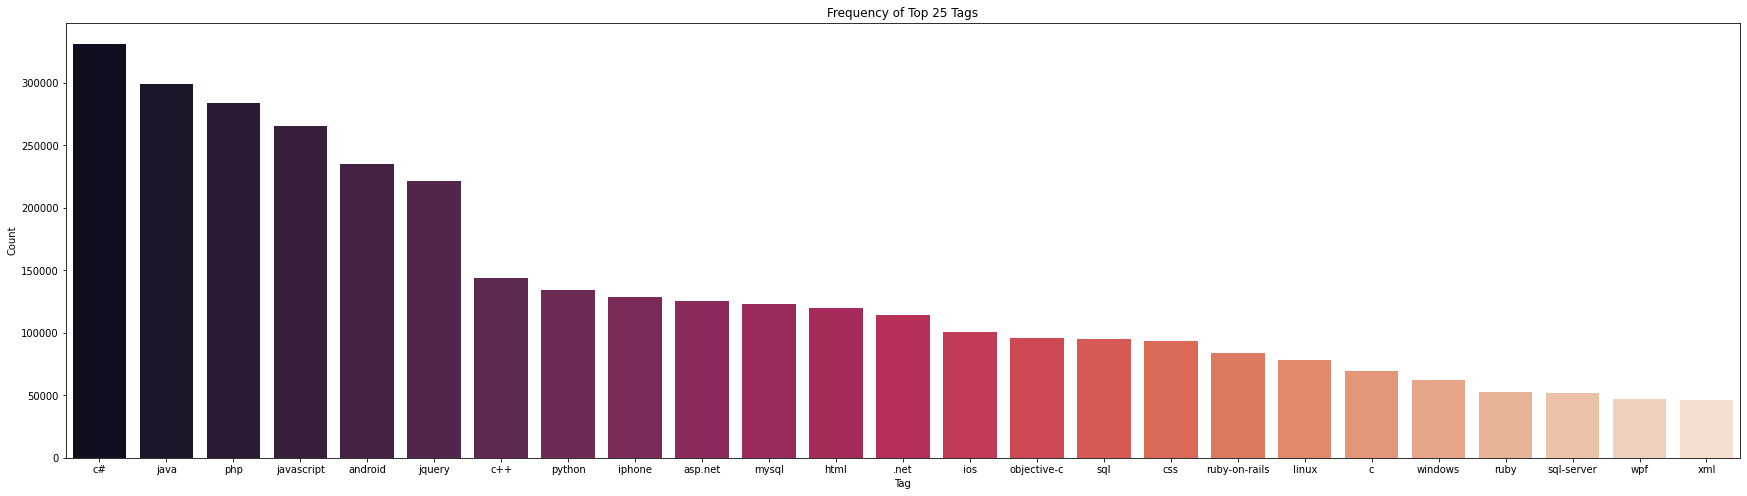

In [12]:
# Plotting top 25 tags
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 8))
plt.title('Frequency of Top 25 Tags')
sns.barplot(x="Tag", y="Count", data=each_tag_count.iloc[0:25, :], palette="rocket");

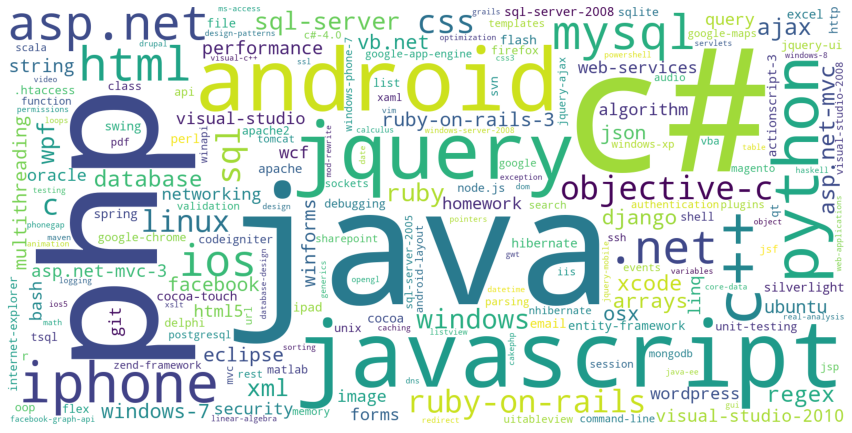

In [13]:
# Word Cloud gives a clear representation of commonly occurring words 

d = {}
for a, x in each_tag_count.values:
    d[a] = x

import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600,height=800, background_color ='white')
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud)
plt.tight_layout(pad = 0)
plt.axis("off")
plt.show()

## Text Preprocessing

In [14]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

nltk.download('stopwords')
nltk.download('punkt')

stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [15]:
# We can join the text columns
data['question'] = data['Title'] + data['Body']
data = data.drop(['Title', 'Body'], axis=1)
data.head(3)

,Id,Tags,Tag Count,question
0,1,php image-processing file-upload upload mime-t...,5,How to check if an uploaded file is an image w...
1,2,firefox,1,How can I prevent firefox from closing when I ...
2,3,r matlab machine-learning,3,R Error Invalid type (list) for variable<p>I a...


In [16]:
# Total Records
data.shape

(4206314, 4)

In [17]:
data = data.iloc[:200000, :]

It will take a lot of time to process 42 lakhs data points. Let us consider 2 lakh data points for ease of calculation.

In [18]:
import re

def strip_html_tags(sentence):
    cleaner = re.compile('<.*?>')
    cleantext = re.sub(cleaner, ' ', str(sentence))
    return cleantext

def remove_URL(sentence):
    """Remove URLs from a text string"""
    return re.sub(r"http\S+", "", sentence)

def remove_punctuations(sentence):
  # Should not remove +, space and # as they are part of programming language name
  punctuations = '''=!()-[]{};:'"\,<>./?@$%^&*_~'''
  sentence = sentence.translate(str.maketrans('', '', punctuations))
  sentence = re.sub('[0-9]+', '', sentence)
  sentence = sentence.lower()
  return ' '.join(sentence.split())

def remove_stopwords(sentence):
  text_tokens = word_tokenize(sentence)
  tokens_without_sw = [word for word in text_tokens if not word in stop_words]
  filtered_sentence = (" ").join(tokens_without_sw)
  return filtered_sentence

def apply_stemming(sentence):
  text_tokens = word_tokenize(sentence)
  words = [stemmer.stem(word) for word in text_tokens]
  filtered_sentence = (" ").join(words)
  return filtered_sentence

def preprocess(sentence):
  x = strip_html_tags(sentence)
  x = remove_URL(x)
  x = remove_punctuations(x)
  x = remove_stopwords(x)
  x = apply_stemming(x)
  return x

In [19]:
# Checking preprocess function on random question
GREEN = '\033[92m'
YELLOW = '\033[93m'

print(f"{YELLOW}Actual question statement:\n{data['question'][6]}\n")
print('-'*200)
cleaned_text = preprocess(data['question'][6])
print(f'{GREEN}Preprocessed question statement:\n{cleaned_text}')

Actual question statement:
How to draw barplot in this way with Coreplot<p>My image is cannot post so  the link is my picture </p>

<p><img src="http://i.stack.imgur.com/bA7Tz.jpg" alt="http://m1.img.libdd.com/farm4/2013/0528/10/959DCB60497E3C74E998958C2F4674DB2E9198943E62C_1280_487.jpg"></p>

<p>I want to draw a chart like the image in iOS app </p>

<p>I use the CorePlot to help me to make this </p>

<p>My Question:</p>

<ol>
<li><p>How to draw 3 barPlot whit  3 kinds color </p></li>
<li><p>How to draw a barPlot from the CPTXYAxis  0  to   -4000  in the Upside down way </p></li>
</ol>

<p>Any help would be appreciate</p>

<p>Thanks all</p>


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Preprocessed question statement:
draw barplot way coreplot imag post link pictur want draw chart like imag io app use coreplot help make question dr

In [20]:
# Applying preprocess function on whole data
data['Filtered questions'] = data['question'].apply(preprocess)

In [21]:
data = data.drop(['question', 'Tag Count', 'Id'], axis=1)
data.head(3)

,Tags,Filtered questions
0,php image-processing file-upload upload mime-t...,check upload file imag without mime type id li...
1,firefox,prevent firefox close press ctrlw favorit edit...
2,r matlab machine-learning,r error invalid type list variabl import matla...


## Multi Label Conversion

In [22]:
# Converting string Tags to multilable output variables
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
BOW = vectorizer.fit_transform(data['Tags'])                                      # Bag of words (or Tags)

In [23]:
BOW.shape

(200000, 23765)

In [24]:
import numpy as np
# Summing up appearance of each tag in a record or row
tag_count_sum = BOW.sum(axis = 0).A1                                              # Sum corresponding to each column or tag
sorted_tags = np.argsort(-tag_count_sum)                                          # Indices of most occuring tags.
sorted_tags

array([ 2550, 10270, 15376, ...,  7670, 15030, 11882])

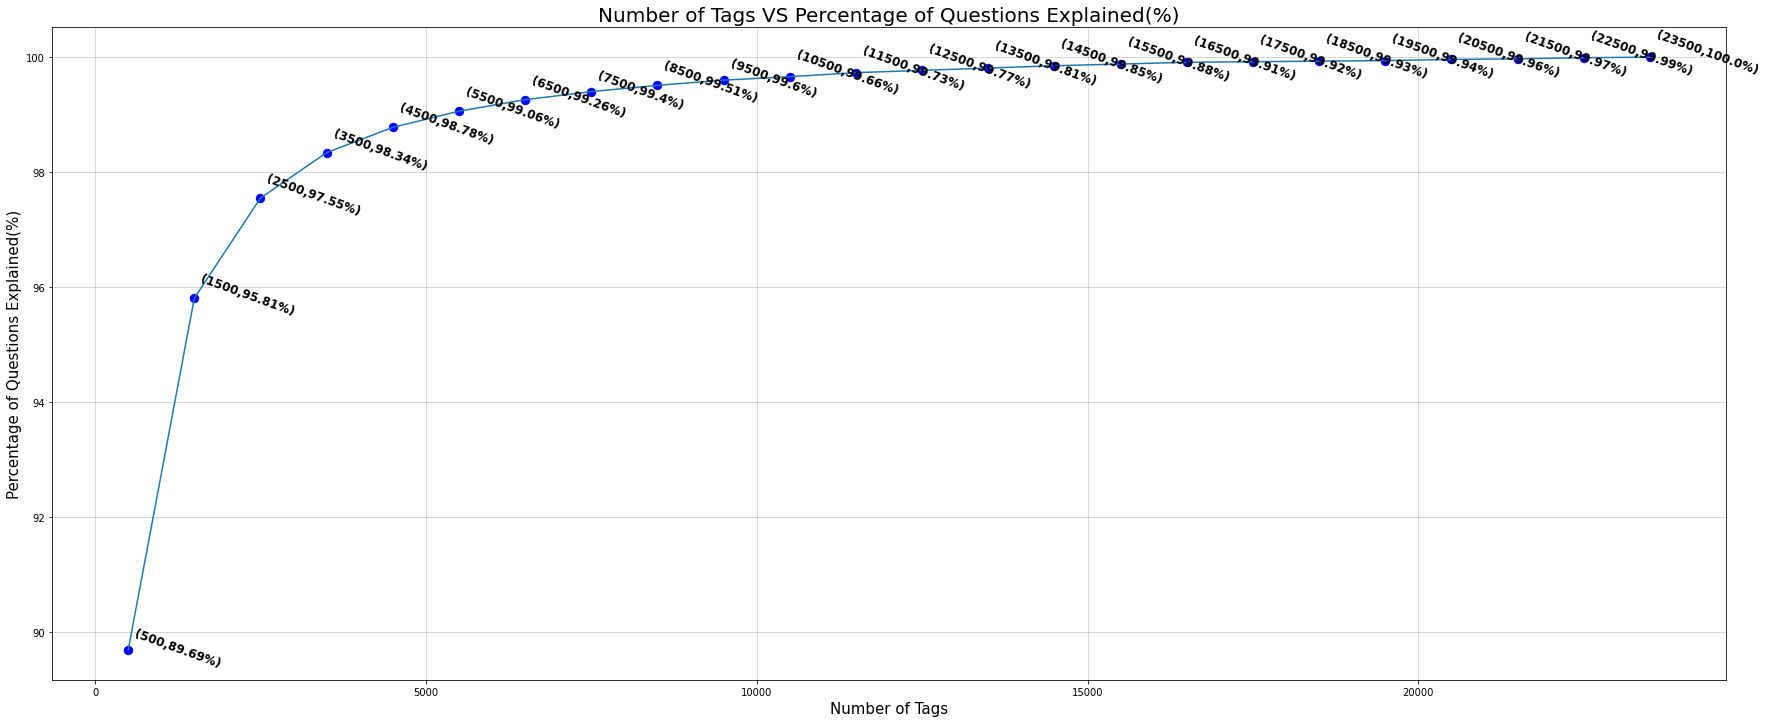

In [25]:
def top_n_tags(n):
    multilabel_yn = BOW[:,sorted_tags[:n]]                                        # This will select all rows from bag of words and n columns from the sorted_tags
    return multilabel_yn

def questionsCovered(n):
    multilabel_yn = top_n_tags(n)                                                 # Selecting top n tags by entering the index number. Till which index we are interested in selecting tags.
    sum_of_tag_counts = multilabel_yn.sum(axis = 1)                               # Sum of tag counts
    tags_with_non_zero_sum = np.count_nonzero(sum_of_tag_counts)                  # There can be few tags which are ommitted while selecting top n tags due low frequency of occurrance. So we are summing only non zero tags.
    return tags_with_non_zero_sum, sum_of_tag_counts

questionsExplained = []
numberOfTags = []

for i in range(500, BOW.shape[1], 1000):
    questionsExplained.append(round((questionsCovered(i)[0]/BOW.shape[0])*100,2))
    numberOfTags.append(i)
    
plt.figure(figsize = (30, 12))
plt.plot(numberOfTags, questionsExplained)
plt.title("Number of Tags VS Percentage of Questions Explained(%)", fontsize=20)
plt.xlabel("Number of Tags", fontsize=15)
plt.ylabel("Percentage of Questions Explained(%)", fontsize=15)
plt.scatter(x = numberOfTags, y = questionsExplained, c = "blue", s = 70)
for x, y in zip(numberOfTags, questionsExplained):
    plt.annotate(s = '({},{}%)'.format(x, y), xy = (x, y), fontweight='bold', fontsize = 12, xytext=(x+70, y-0.3), rotation = -20)
plt.grid(linestyle='-', linewidth=0.5)

In [26]:
# Removing rows from data where tags occurs very few times.

sumOfRows = questionsCovered(500)[1]                                              # Considering n = 500
RowIndicesZero = np.where(sumOfRows == 0)[0]                                      # this contains indices of all the questions for which the tags are removed
processed_data = data.drop(labels = RowIndicesZero, axis = 0)
processed_data.reset_index(drop = True, inplace = True)
print("Shape of processed data = ",processed_data.shape)

Shape of processed data =  (179385, 2)


In [27]:
# Joining featurized tags into processed data
data_tags = top_n_tags(500)                                                       # Selecting top n tags
df = pd.DataFrame(data_tags.toarray())                                            # Converting into dataframe
features_data = df.drop(labels = RowIndicesZero, axis = 0)                        # Removing rows with indices 0
features_data.reset_index(drop = True, inplace = True)
print("Shape of vectorized featues = ",features_data.shape)

Shape of vectorized featues =  (179385, 500)


In [28]:
def tags_check(n):
    tagRow = features_data.iloc[n]
    tagRowNonZero = np.where(tagRow==1)[0]
    for i in tagRowNonZero:
        print(vectorizer.get_feature_names()[sorted_tags[i]])
    print('-'*25)
    print(processed_data['Tags'][n])

tags_check(6)

c#
asp.net
windows-phone-7
-------------------------
c# asp.net windows-phone-7


In [29]:
processed_data.head(3)

,Tags,Filtered questions
0,php image-processing file-upload upload mime-t...,check upload file imag without mime type id li...
1,firefox,prevent firefox close press ctrlw favorit edit...
2,r matlab machine-learning,r error invalid type list variabl import matla...


## Train Test Split

In [30]:
data_tags = top_n_tags(500)
df = pd.DataFrame(data_tags.toarray())
TagsDF_new = df.drop(labels = RowIndicesZero, axis = 0)
TagsDF_new.reset_index(drop = True, inplace = True)
print("Size of new data = ",TagsDF_new.shape[0])

Size of new data =  179385


In [31]:
from scipy.sparse import csr_matrix
# Let's consider 75% data as train data
processed_data = processed_data.drop(['Tags'], axis=1)

no_of_records_in_processed_data = len(processed_data)
no_of_records_in_train_data = int(0.75*no_of_records_in_processed_data)

X_train = processed_data.iloc[:no_of_records_in_train_data, :]
X_test = processed_data.iloc[no_of_records_in_train_data:, :]

all_features = csr_matrix(TagsDF_new.values)
y_train = all_features[0:no_of_records_in_train_data]
y_test = all_features[no_of_records_in_train_data:]

print("Train data shape ", X_train.shape)
print("Train label shape", y_train.shape)
print("Test data shape ", X_test.shape)
print("Test label shape", y_test.shape)

Train data shape  (134538, 1)
Train label shape (134538, 500)
Test data shape  (44847, 1)
Test label shape (44847, 500)


## Featurizing X labels

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df = 0.001, max_features = 50000, ngram_range = (1,3), tokenizer = lambda x: x.split(" "))
train_data = vectorizer.fit_transform(X_train['Filtered questions'])
test_data = vectorizer.transform(X_test['Filtered questions'])

In [33]:
print(f"Dimension of train data = {train_data.shape}")
print(f"Dimension of test data = {test_data.shape}")

Dimension of train data = (134538, 6965)
Dimension of test data = (44847, 6965)


# Machine Learning Model

In [34]:
# Functon for running the model
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, accuracy_score

def run_model(loss_type, alpha_value, penalty_type, X_train, X_test, y_train, y_test):
  classifier = OneVsRestClassifier(SGDClassifier(loss=loss_type, alpha=alpha_value, penalty=penalty_type), n_jobs=1)
  classifier.fit(X_train, y_train)
  predictions = classifier.predict(X_test)
  print("Accuracy :",accuracy_score(y_test,predictions))
  print("Micro f1 score :",f1_score(y_test, predictions, average = 'micro'))

## Logistic Regression with One-Vs-Rest Classifier
- SGD with log as loss is Logistic Regression

In [35]:
run_model('log', 0.000001, 'l2', train_data, test_data, y_train, y_test)

Accuracy : 0.18386960108814412
Micro f1 score : 0.5010065280533746


## Support Vector Machine with One-Vs-Rest Classifier
- SGD with hinge as loss is Support Vector Classifier

In [36]:
run_model('hinge', 0.000001, 'l2', train_data, test_data, y_train, y_test)

Accuracy : 0.18520748322072825
Micro f1 score : 0.509015400588337
